In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
print(pd.__version__)
import re
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import classification_report, mean_squared_error, accuracy_score
from collections import Counter

1.3.0


In [2]:
# Read in gun violence data
gv_df = pd.read_excel('C:/Users/mattg/Desktop/BU_Classes/CS_640/Final_Project/data.xlsx',index_col=0) # Change as needed for individual runs

In [114]:
gv_df.head(1)

,imageID,article_url,headline,body,google_visual_api_web_entities_detection_on_lead_image,automatically_generated_caption_of_lead_image,lead_3_sentences_summary_of_full_article_text,presum_summary_of_full_article_text,Q1 Relevant,Q2 Focus,Q3 Theme1,Q3 Theme2,V1image,V2ethnicity,V3relevance,V4relevance,Q4 Image1,Q4 Image2
index,,,,,,,,,,,,,,,,,,
0,10057,http://beta.latimes.com/nation/la-na-paddock-c...,Cremated remains of Las Vegas mass shooter to ...,"""Cremated remains of Las Vegas mass shooter to...",Stephen Paddock 2017 Las Vegas Strip shooting ...,"Eric Paddock, center, with his brother Eric Pa...","""Cremated remains of Las Vegas mass shooter to...","""cremated remains of las vegas mass shooter to...",1,2,7,99,1,0,0,99.0,6,99


In [3]:
# Changing number labels to text labels for columns relevant to Project 1

q1 = {1: "Yes", 2: "No"}
q2 = {1: "One incident", 2: "Ongoing Issue"}
q3 = {1: "Gun/2nd Amendment", 2: "Gun Control", 3: "Politics", 4: "Mental Health", 5: "School/Public Safety", 6: "Race/Ethnicity", 7: "Public Opinion", 8: "Society/culture", 9: "Economic Consequences", 99: "Other"}
gv_df = gv_df.replace({"Q1 Relevant": q1})
gv_df = gv_df.replace({"Q2 Focus": q2})
gv_df = gv_df.replace({"Q3 Theme1": q3})
gv_df = gv_df.replace({"Q3 Theme2": q3})
gv_df["Q4 Image1"] = gv_df["Q4 Image1"].astype(str)
gv_df["Q4 Image2"] = gv_df["Q4 Image1"].astype(str)

TypeError: 'Text' object is not callable

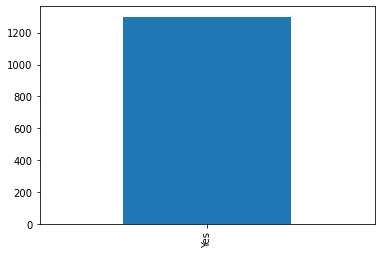

In [33]:
# Plot of if article is about gun violence in the United States (Yes/No)

gv_df['Q1 Relevant'].value_counts().plot(kind='bar')

<AxesSubplot:>

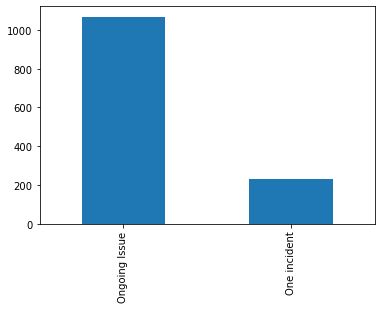

In [187]:
# Plot of the focus of the news story

gv_df['Q2 Focus'].value_counts().plot(kind='bar')

<AxesSubplot:>

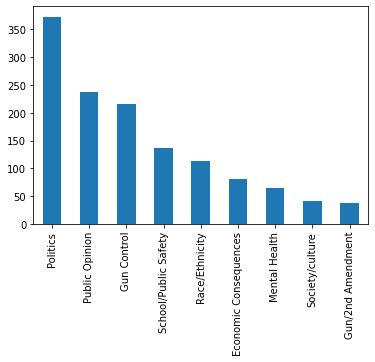

In [186]:
# Plot of the main theme [Q3 Theme1] of each news story

#fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
#fig.suptitle('Sharing x per column, y per row')
#gv_df['Q1 Relevant'].value_counts().plot(kind='bar')
#gv_df['Q2 Focus'].value_counts().plot(kind='bar')
gv_df['Q3 Theme1'].value_counts().plot(kind='bar')
#gv_df['Q4 Image1'].value_counts().plot(kind='bar')

#for ax in fig.get_axes():
#    ax.label_outer()

<AxesSubplot:>

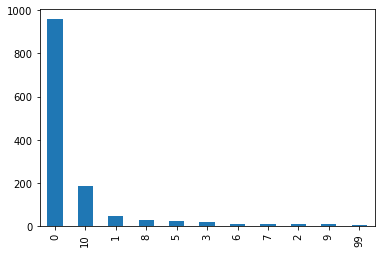

In [188]:
# Plot of scores 0-10 for the extent that the image represents the first theme (Q3-1) of the news story
gv_df['Q4 Image1'].value_counts().plot(kind='bar')

Data's shape is  (1300, 18)

      imageID                                        article_url  \
index                                                              
0       10057  http://beta.latimes.com/nation/la-na-paddock-c...   
1       10073  https://www.yahoo.com/news/florida-shooter-tro...   
2       10107  http://www.chicagotribune.com/suburbs/lake-cou...   
3       10112  http://www.chicagotribune.com/suburbs/post-tri...   
4       10156  http://www.cnn.com/2018/02/16/us/exclusive-sch...   

                                                headline  \
index                                                      
0      Cremated remains of Las Vegas mass shooter to ...   
1      Florida shooter a troubled loner with white su...   
2      Vernon Hills teen accused of wearing white sup...   
3      Griffith student charged with accidentally bri...   
4      Exclusive: Group chat messages show school sho...   

                                                    body  \
index        

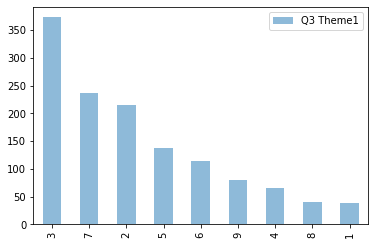

In [115]:
print("Data's shape is ", gv_df.shape)

print()

print(gv_df.head())

print()

print(gv_df.describe())

gv_df['Q3 Theme1'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

In [189]:
# Most common words from headline
stopwords = nltk.corpus.stopwords.words('english')
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
hlWords = (gv_df.headline.str.lower().replace([r'\|', RE_stopwords], [' ', ''], regex=True).str.cat(sep=' ').split())
hlRslt = pd.DataFrame(Counter(hlWords).most_common(25), columns=['Word', 'Frequency']).set_index('Word')

In [192]:
hlRslt

,Frequency
Word,
gun,465
shooting,334
school,144
trump,132
',121
nra,114
guns,111
control,106
synagogue,90


In [193]:
# Most common words from body
stopwords = nltk.corpus.stopwords.words('english')
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))
bodyWords = (gv_df.body.str.lower().replace([r'\|', RE_stopwords], [' ', ''], regex=True).str.cat(sep=' ').split())
bodyRslt = pd.DataFrame(Counter(bodyWords).most_common(25), columns=['Word', 'Frequency']).set_index('Word')

In [65]:
# Strategy 1: Linear Regression Model w/o text parameters
X_train, X_test, Y_train, Y_test = train_test_split(
        gv_df[['Q1 Relevant','Q2 Focus', 'Q3 Theme2', 'V1image', 'V2ethnicity', 'V3relevance', 'V4relevance', 'Q4 Image1','Q4 Image2']],
        gv_df['Q3 Theme1'],
        test_size=1/4.0,
        random_state=0
)

linreg = LinearRegression().fit(X_train, Y_train)
lin_y_preds = linreg.predict(X_test)
print("RMSE on Linear Regression testing set = ", mean_squared_error(Y_test, lin_y_preds))

linreg_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':lin_y_preds})

RMSE on Linear Regression testing set =  4.754551328767349


In [67]:
# Sample results of Linear Regression Model
linreg_results

,Y_test,y_preds
index,,
940,7,5.651304
476,3,3.694356
1032,5,5.600442
241,3,4.315634
1258,3,5.219416
...,...,...
82,4,4.284605
514,3,4.129965
845,3,4.551238


In [109]:
# Strategy 2: Logistic Regression Model w/o text parameters
X_train, X_test, Y_train, Y_test = train_test_split(
        gv_df[['Q1 Relevant','Q2 Focus', 'Q3 Theme2', 'V1image', 'V2ethnicity', 'V3relevance', 'V4relevance', 'Q4 Image1','Q4 Image2']],
        gv_df['Q3 Theme1'],
        test_size=1/4.0,
        random_state=0
)
logreg = LogisticRegression(random_state=0).fit(X_train, Y_train)
log_y_preds = logreg.predict(X_test)
print("RMSE on Logistic Regression testing set = ", mean_squared_error(Y_test, log_y_preds))

logreg_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':log_y_preds})

RMSE on Logistic Regression testing set =  7.694444444444445


C:\Users\mattg\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [110]:
logreg_results

,Y_test,y_preds
index,,
940,7,7
476,3,3
1032,5,7
241,3,3
1258,3,7
...,...,...
82,4,4
514,3,3
845,3,2


In [72]:
# Strategy 3: Random Forest w/o text parameters
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

gv_df = gv_df.replace([np.inf, -np.inf], np.nan)
gv_df = gv_df.dropna()

X_train, X_test, Y_train, Y_test = train_test_split(gv_df[['Q1 Relevant','Q2 Focus', 'Q3 Theme2', 'V1image', 'V2ethnicity', 'V3relevance', 'V4relevance', 'Q4 Image1','Q4 Image2']],
                                                          gv_df['Q3 Theme1'],
                                                          test_size=1/4.0,
                                                          random_state=0
                                                 )


rfreg = RandomForestRegressor(n_estimators=1000, random_state = 0)
rfreg.fit(X_train, Y_train)
rf_y_preds = rfreg.predict(X_test)

rfresults = pd.DataFrame({'Y_test':Y_test, 'y_preds':y_preds})
print("RMSE on RF testing set = ", mean_squared_error(Y_test, rf_y_preds))

RMSE on RF testing set =  3.5354370343710193


In [62]:
rfresults

,Y_test,y_preds
index,,
940,7,6.452584
476,3,3.000000
1032,5,4.652200
241,3,3.000000
1258,3,2.089365
...,...,...
82,4,4.000000
514,3,3.076995
845,3,2.506529


In [73]:
svm_hl_results

,Y_test,y_preds
index,,
940,7,6
476,3,3
1032,5,5
241,3,7
1258,3,7
...,...,...
82,4,6
514,3,3
845,3,7


In [128]:
# Strategy 4: SVM on headline parameter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Load in tfidf
tfidf = TfidfVectorizer(max_features=2800)

# Create variables from gv_df to train_test_split
X_hl = gv_df['headline'].astype(pd.StringDtype())
X_hl = tfidf.fit_transform(X_hl.values.astype('U'))
y = gv_df['Q3 Theme1']

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_hl,
        y,
        test_size=0.25,
        random_state=0
    )

# Load in classifier for SVM
svm = LinearSVC()
svm.fit(X_train, Y_train)
svm_hl_y_preds = svm.predict(X_test)

#print("RMSE on SVM body testing set = ", mean_squared_error(Y_test, svm_body_y_preds))
print("Accuracy Score on SVM body testing set = ", accuracy_score(Y_test, svm_hl_y_preds))
svm_hl_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':svm_hl_y_preds})

Accuracy Score on SVM body testing set =  0.7323076923076923


In [129]:
svm_hl_results

,Y_test,y_preds
index,,
579,6,3
1014,8,3
759,7,7
446,3,3
186,7,7
...,...,...
638,7,7
440,2,2
737,4,4


In [98]:
# Strategy 5: SVM on body parameter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Load in tfidf
tfidf = TfidfVectorizer(max_features=2800)

# Create variables from gv_df to train_test_split
X_body = gv_df['body'].astype(pd.StringDtype())
X_body = tfidf.fit_transform(X_body.values.astype('U'))
y = gv_df['Q3 Theme1']

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_body,
        y,
        test_size=0.25,
        random_state=0
    )

# Load in classifier for SVM
svm = LinearSVC()
svm.fit(X_train, Y_train)
svm_body_y_preds = svm.predict(X_test)

#print("RMSE on SVM body testing set = ", mean_squared_error(Y_test, svm_body_y_preds))
print("Accuracy Score on SVM body testing set = ", accuracy_score(Y_test, svm_body_y_preds))
svm_body_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':svm_body_y_preds})

RMSE on SVM body testing set =  2.8117283950617282
Accuracy Score on SVM body testing set =  0.6790123456790124


In [69]:
svm_body_results

,Y_test,y_preds
index,,
940,7,7
476,3,3
1032,5,5
241,3,3
1258,3,3
...,...,...
82,4,6
514,3,5
845,3,7


In [96]:
# Strategy 6: SVM on google_visual_api_web_entities_detection_on_lead_image parameter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Load in tfidf
tfidf = TfidfVectorizer(max_features=2800)

# Create variables from gv_df to train_test_split
X_google = gv_df['google_visual_api_web_entities_detection_on_lead_image'].astype(pd.StringDtype())
X_google = tfidf.fit_transform(X_google.values.astype('U'))
y = gv_df['Q3 Theme1']

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_google,
        y,
        test_size=0.25,
        random_state=0
    )

# Load in classifier for SVM
svm = LinearSVC()
svm.fit(X_train, Y_train)
svm_google_y_preds = svm.predict(X_test)

#print("RMSE on SVM google_visual_api_web_entities_detection_on_lead_image testing set = ", mean_squared_error(Y_test, svm_google_y_preds))
print("Accuracy Score on SVM google_visual_api_web_entities_detection_on_lead_image testing set = ", accuracy_score(Y_test, svm_google_y_preds))
svm_google_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':svm_google_y_preds})

RMSE on SVM google_visual_api_web_entities_detection_on_lead_image testing set =  6.984567901234568
Accuracy Score on SVM google_visual_api_web_entities_detection_on_lead_image testing set =  0.4722222222222222


In [82]:
svm_google_results

,Y_test,y_preds
index,,
940,7,6
476,3,3
1032,5,5
241,3,7
1258,3,6
...,...,...
82,4,8
514,3,3
845,3,7


In [95]:
# Strategy 7: SVM on automatically_generated_caption_of_lead_image parameter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Load in tfidf
tfidf = TfidfVectorizer(max_features=2800)

# Create variables from gv_df to train_test_split
X_auto = gv_df['automatically_generated_caption_of_lead_image'].astype(pd.StringDtype())
X_auto = tfidf.fit_transform(X_auto.values.astype('U'))
y = gv_df['Q3 Theme1']

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_auto,
        y,
        test_size=0.25,
        random_state=0
    )

# Load in classifier for SVM
svm = LinearSVC()
svm.fit(X_train, Y_train)
svm_auto_y_preds = svm.predict(X_test)

#print("RMSE on SVM automatically_generated_caption_of_lead_image testing set = ", mean_squared_error(Y_test, svm_auto_y_preds))
print("Accuracy Score on SVM automatically_generated_caption_of_lead_image testing set = ", accuracy_score(Y_test, svm_auto_y_preds))
svm_auto_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':svm_auto_y_preds})

RMSE on SVM automatically_generated_caption_of_lead_image testing set =  6.700617283950617
Accuracy Score on SVM automatically_generated_caption_of_lead_image testing set =  0.5


In [84]:
svm_auto_results

,Y_test,y_preds
index,,
940,7,3
476,3,3
1032,5,5
241,3,3
1258,3,6
...,...,...
82,4,2
514,3,6
845,3,7


In [94]:
# Strategy 8: SVM on lead_3_sentences_summary_of_full_article_text parameter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Load in tfidf
tfidf = TfidfVectorizer(max_features=2800)

# Create variables from gv_df to train_test_split
X_lead3 = gv_df['lead_3_sentences_summary_of_full_article_text'].astype(pd.StringDtype())
X_lead3 = tfidf.fit_transform(X_lead3.values.astype('U'))
y = gv_df['Q3 Theme1']

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_lead3,
        y,
        test_size=0.25,
        random_state=0
    )

# Load in classifier for SVM
svm = LinearSVC()
svm.fit(X_train, Y_train)
svm_lead3_y_preds = svm.predict(X_test)

#print("RMSE on SVM lead_3_sentences_summary_of_full_article_text testing set = ", mean_squared_error(Y_test, svm_lead3_y_preds))
print("Accuracy Score on SVM lead_3_sentences_summary_of_full_article_text testing set = ", accuracy_score(Y_test, svm_lead3_y_preds))
svm_lead3_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':svm_lead3_y_preds})

RMSE on SVM lead_3_sentences_summary_of_full_article_text testing set =  4.682098765432099
Accuracy Score on SVM lead_3_sentences_summary_of_full_article_text testing set =  0.5771604938271605


In [88]:
svm_lead3_results

,Y_test,y_preds
index,,
940,7,6
476,3,3
1032,5,5
241,3,3
1258,3,6
...,...,...
82,4,6
514,3,2
845,3,7


In [93]:
# Strategy 9: SVM on presum_summary_of_full_article_text parameter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Load in tfidf
tfidf = TfidfVectorizer(max_features=2800)

# Create variables from gv_df to train_test_split
X_presum = gv_df['presum_summary_of_full_article_text'].astype(pd.StringDtype())
X_presum = tfidf.fit_transform(X_presum.values.astype('U'))
y = gv_df['Q3 Theme1']

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_presum,
        y,
        test_size=0.25,
        random_state=0
    )

# Load in classifier for SVM
svm = LinearSVC()
svm.fit(X_train, Y_train)
svm_presum_y_preds = svm.predict(X_test)

#print("RMSE on SVM presum_summary_of_full_article_text testing set = ", mean_squared_error(Y_test, svm_presum_y_preds))
print("Accuracy Score on SVM presum_summary_of_full_article_text testing set = ", accuracy_score(Y_test, svm_presum_y_preds))
svm_presum_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':svm_presum_y_preds})

RMSE on SVM presum_summary_of_full_article_text testing set =  4.169753086419753
Accuracy Score on SVM presum_summary_of_full_article_text testing set =  0.5895061728395061


In [90]:
svm_presum_results

,Y_test,y_preds
index,,
940,7,7
476,3,3
1032,5,5
241,3,3
1258,3,6
...,...,...
82,4,4
514,3,2
845,3,7


Max Accuracy Score on SVM headline testing set =  0.038461538461538464  at max features =  10


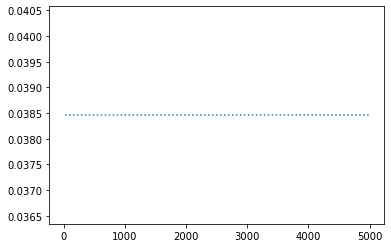

In [38]:
# Strategy 10: SVM on headline parameter w/ loop to tune max features

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

x_values = []
accuracy_scores = []
max_feat_num = 0
max_acc_score = 0

for x in range(1, 500):
    feat_num = x*10

    # Load in tfidf
    tfidf = TfidfVectorizer(max_features=feat_num)
    x_values.append(feat_num)

    # Create variables from gv_df to train_test_split
    X_hl = gv_df['body'].astype(pd.StringDtype())
    X_hl = tfidf.fit_transform(X_hl.values.astype('U'))
    y = gv_df['Q3 Theme1']

    # Split training set into training and testing set
    X_train, X_test, Y_train, Y_test = train_test_split(
            X_hl,
            y,
            test_size=0.25,
            random_state=0
        )

    # Load in classifier for SVM
    svm = LinearSVC()
    svm.fit(X_train, Y_train)
    svm_hl_y_preds = svm.predict(X_test)
    accuracy_scores.append(acc_score)
    if (acc_score > max_acc_score):
        max_acc_score = acc_score
        max_feat_num = feat_num
    
plt.plot(x_values, accuracy_scores, linestyle = 'dotted')

#print("RMSE on SVM headline testing set = ", mean_squared_error(Y_test, svm_hl_y_preds))
print("Max Accuracy Score on SVM headline testing set = ", max_acc_score, " at max features = ",  max_feat_num)
svm_hl_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':svm_hl_y_preds})

Max Accuracy Score on SVM google testing set data after selecting relevant images =  0.7107692307692308  at max features =  680


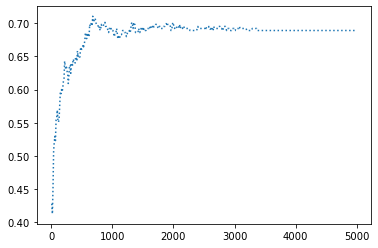

In [134]:
# Strategy 11: SVM on google_visual_api_web parameter after using only rows with relevant w/ Q4 image >= 5 
# and w/ loop to tune max features

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

x_values = []
accuracy_scores = []
max_feat_num = 0
max_acc_score = 0

rel_goog_gv_df = gv_df[gv_df['Q4 Image1'] >= 6]
rel_goog_gv_df = gv_df[gv_df['Q4 Image1'] != 99]

for x in range(1, 500):
    feat_num = x*10

    # Load in tfidf
    tfidf = TfidfVectorizer(max_features=feat_num)
    x_values.append(feat_num)

    # Create variables from gv_df to train_test_split
    X_google = rel_goog_gv_df['headline'].astype(pd.StringDtype())
    X_google = tfidf.fit_transform(X_google.values.astype('U'))
    y = rel_goog_gv_df['Q3 Theme1']

    # Split training set into training and testing set
    X_train, X_test, Y_train, Y_test = train_test_split(
            X_google,
            y,
            test_size=0.25,
            random_state=0
        )

    # Load in classifier for SVM
    svm = LinearSVC()
    svm.fit(X_train, Y_train)
    svm_google_y_preds = svm.predict(X_test)
    acc_score = accuracy_score(Y_test, svm_google_y_preds)
    accuracy_scores.append(acc_score)
    if (acc_score > max_acc_score):
        max_acc_score = acc_score
        max_feat_num = feat_num
    
plt.plot(x_values, accuracy_scores, linestyle = 'dotted')

#print("RMSE on SVM headline testing set = ", mean_squared_error(Y_test, svm_hl_y_preds))
print("Max Accuracy Score on SVM google testing set data after selecting relevant images = ", max_acc_score, " at max features = ",  max_feat_num)
svm_hl_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':svm_google_y_preds})

In [ ]:
# Strategy 12: SVM on headline and body parameters combined together

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

# Load in tfidf
tfidf = TfidfVectorizer(max_features=2800)

# Create variables from gv_df to train_test_split
text_gv_df = gv_df[['headline', 'body']]
text_gv_df['headline'] = gv_df['headline'].astype(pd.StringDtype())
text_gv_df['body'] = gv_df['body'].astype(pd.StringDtype())
text_gv_df['headline'] = gv_df['headline'].astype('U')
text_gv_df['body'] = gv_df['body'].astype('U')
y = gv_df['Q3 Theme1']

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        text_gv_df,
        y,
        test_size=0.25,
        random_state=0
    )

# Load in classifier for SVM
svm = LinearSVC()
svm.fit(X_train, Y_train)
svm_headbod_y_preds = svm.predict(X_test)


#print("RMSE on SVM headline and body combined testing set = ", mean_squared_error(Y_test, svm_headbod_y_preds))
print("Accuracy Score on SVM headline and body combined testing set = ", accuracy_score(Y_test, svm_headbod_y_preds))
svm_presum_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':svm_headbod_y_preds})

Max Accuracy Score on Naive Bayes headline data =  0.5615384615384615  at max features =  250


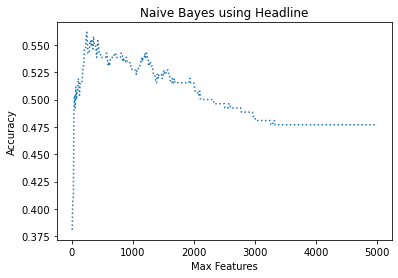

In [4]:
# Strategy 13: Naive Bayes Model on headline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

x_values = []
accuracy_scores = []
max_feat_num = 0
max_acc_score = 0

for x in range(1, 500):
    feat_num = x*10

    # Load in tfidf
    tfidf = TfidfVectorizer(max_features=feat_num)
    x_values.append(feat_num)

    # Create variables from gv_df to train_test_split
    X_hl = gv_df['headline'].astype(pd.StringDtype())
    X_hl = tfidf.fit_transform(X_hl.values.astype('U'))
    y = gv_df['Q3 Theme1']

    # Split training set into training and testing set
    X_train, X_test, Y_train, Y_test = train_test_split(
            X_hl,
            y,
            test_size=0.20,
            random_state=0
        )

    nb = MultinomialNB().fit(X_train, Y_train)
    nb_hl_y_preds = nb.predict(X_test)
    acc_score = accuracy_score(Y_test, nb_hl_y_preds)
    accuracy_scores.append(acc_score)
    if (acc_score > max_acc_score):
        final_hl_y_preds = nb_hl_y_preds
        max_acc_score = acc_score
        max_feat_num = feat_num
    
plt.title('Naive Bayes using Headline')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.plot(x_values, accuracy_scores, linestyle = 'dotted')
#plt.title('Naive Bayes using Headline')
#plt.xtitle('Max Features')
#plt.ytilte('Accuracy')

#print("Accuracy Score on NB headline testing set = ", accuracy_score(Y_test, nb_hl_y_preds))
print("Max Accuracy Score on Naive Bayes headline data = ", max_acc_score, " at max features = ",  max_feat_num)
nb_hl_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':nb_hl_y_preds})

In [5]:
target_names = ["Gun/2nd Amendment", "Gun Control", "Politics", "Mental Health", "School/Public Safety", "Race/Ethnicity", "Public Opinion", "Society/culture", "Economic Consequences"]
print(classification_report(Y_test, final_hl_y_preds, target_names=target_names))

                       precision    recall  f1-score   support

    Gun/2nd Amendment       0.00      0.00      0.00        15
          Gun Control       0.69      0.57      0.62        42
             Politics       0.00      0.00      0.00         7
        Mental Health       0.50      0.08      0.13        13
 School/Public Safety       0.47      0.90      0.62        69
       Race/Ethnicity       0.67      0.69      0.68        55
       Public Opinion       0.69      0.44      0.54        25
      Society/culture       0.56      0.42      0.48        24
Economic Consequences       0.00      0.00      0.00        10

             accuracy                           0.56       260
            macro avg       0.40      0.34      0.34       260
         weighted avg       0.52      0.56      0.51       260



C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Max Accuracy Score on Naive Bayes body data =  0.5038461538461538  at max features =  450


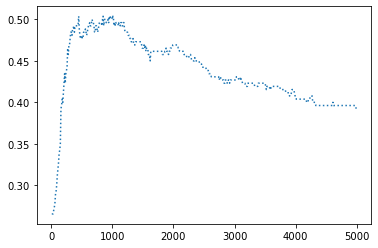

In [6]:
# Strategy 14: Naive Bayes Model on body

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

x_values = []
accuracy_scores = []
max_feat_num = 0
max_acc_score = 0

for x in range(1, 500):
    feat_num = x*10

    # Load in tfidf
    tfidf = TfidfVectorizer(max_features=feat_num)
    x_values.append(feat_num)

    # Create variables from gv_df to train_test_split
    X_body = gv_df['body'].astype(pd.StringDtype())
    X_body = tfidf.fit_transform(X_body.values.astype('U'))
    y = gv_df['Q3 Theme1']

    # Split training set into training and testing set
    X_train, X_test, Y_train, Y_test = train_test_split(
            X_body,
            y,
            test_size=0.20,
            random_state=0
        )

    nb = MultinomialNB().fit(X_train, Y_train)
    nb_body_y_preds = nb.predict(X_test)
    acc_score = accuracy_score(Y_test, nb_body_y_preds)
    accuracy_scores.append(acc_score)
    if (acc_score > max_acc_score):
        max_acc_score = acc_score
        max_feat_num = feat_num
    
plt.plot(x_values, accuracy_scores, linestyle = 'dotted')

#print("Accuracy Score on NB body testing set = ", accuracy_score(Y_test, nb_body_y_preds))
print("Max Accuracy Score on Naive Bayes body data = ", max_acc_score, " at max features = ",  max_feat_num)
nb_body_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':nb_body_y_preds})

In [61]:
target_names = ["Gun/2nd Amendment", "Gun Control", "Politics", "Mental Health", "School/Public Safety", "Race/Ethnicity", "Public Opinion", "Society/culture", "Economic Consequences"]
print(classification_report(Y_test, nb_body_y_preds, target_names=target_names))

C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'                       precision    recall  f1-score   support\n\n    Gun/2nd Amendment       0.00      0.00      0.00         9\n          Gun Control       0.92      0.20      0.33        55\n             Politics       0.31      0.98      0.47        89\n        Mental Health       0.00      0.00      0.00        17\n School/Public Safety       0.00      0.00      0.00        32\n       Race/Ethnicity       1.00      0.26      0.41        27\n       Public Opinion       0.67      0.27      0.38        67\n      Society/culture       0.00      0.00      0.00        11\nEconomic Consequences       0.00      0.00      0.00        18\n\n             accuracy                           0.38       325\n            macro avg       0.32      0.19      0.18       325\n         weighted avg       0.46      0.38      0.30       325\n'

Max Accuracy Score on Naive Bayes Google API image data =  0.5230769230769231  at max features =  480


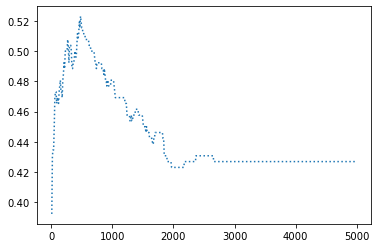

In [7]:
# Strategy 15: Naive Bayes Model on google_visual_api_web_entities_detection_on_lead_image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

x_values = []
accuracy_scores = []
max_feat_num = 0
max_acc_score = 0

for x in range(1, 500):
    feat_num = x*10

    # Load in tfidf
    tfidf = TfidfVectorizer(max_features=feat_num)
    x_values.append(feat_num)

    # Create variables from gv_df to train_test_split
    X_goog = gv_df['google_visual_api_web_entities_detection_on_lead_image'].astype(pd.StringDtype())
    X_goog = tfidf.fit_transform(X_goog.values.astype('U'))
    y = gv_df['Q3 Theme1']

    # Split training set into training and testing set
    X_train, X_test, Y_train, Y_test = train_test_split(
            X_goog,
            y,
            test_size=0.20,
            random_state=0
        )

    nb = MultinomialNB().fit(X_train, Y_train)
    nb_goog_y_preds = nb.predict(X_test)
    acc_score = accuracy_score(Y_test, nb_goog_y_preds)
    accuracy_scores.append(acc_score)
    if (acc_score > max_acc_score):
        max_acc_score = acc_score
        max_feat_num = feat_num
    
plt.plot(x_values, accuracy_scores, linestyle = 'dotted')

#print("Accuracy Score on NB body testing set = ", accuracy_score(Y_test, nb_body_y_preds))
print("Max Accuracy Score on Naive Bayes Google API image data = ", max_acc_score, " at max features = ",  max_feat_num)
nb_goog_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':nb_goog_y_preds})

In [63]:
target_names = ["Gun/2nd Amendment", "Gun Control", "Politics", "Mental Health", "School/Public Safety", "Race/Ethnicity", "Public Opinion", "Society/culture", "Economic Consequences"]
classification_report(Y_test, nb_goog_y_preds, target_names=target_names)

C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'                       precision    recall  f1-score   support\n\n    Gun/2nd Amendment       0.00      0.00      0.00         9\n          Gun Control       0.41      0.20      0.27        55\n             Politics       0.37      0.92      0.53        89\n        Mental Health       0.00      0.00      0.00        17\n School/Public Safety       0.50      0.06      0.11        32\n       Race/Ethnicity       0.67      0.37      0.48        27\n       Public Opinion       0.52      0.43      0.47        67\n      Society/culture       0.00      0.00      0.00        11\nEconomic Consequences       0.33      0.06      0.10        18\n\n             accuracy                           0.42       325\n            macro avg       0.31      0.23      0.22       325\n         weighted avg       0.40      0.42      0.34       325\n'

Max Accuracy Score on Naive Bayes Auto-generated image caption data =  0.4576923076923077  at max features =  170


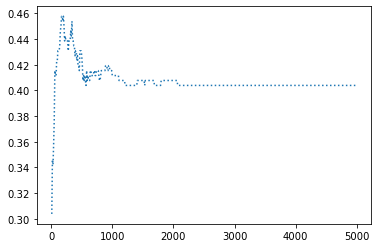

In [8]:
# Strategy 16: Naive Bayes Model on automatically_generated_caption_of_lead_image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

x_values = []
accuracy_scores = []
max_feat_num = 0
max_acc_score = 0

for x in range(1, 500):
    feat_num = x*10

    # Load in tfidf
    tfidf = TfidfVectorizer(max_features=feat_num)
    x_values.append(feat_num)

    # Create variables from gv_df to train_test_split
    X_auto = gv_df['automatically_generated_caption_of_lead_image'].astype(pd.StringDtype())
    X_auto = tfidf.fit_transform(X_auto.values.astype('U'))
    y = gv_df['Q3 Theme1']

    # Split training set into training and testing set
    X_train, X_test, Y_train, Y_test = train_test_split(
            X_auto,
            y,
            test_size=0.20,
            random_state=0
        )

    nb = MultinomialNB().fit(X_train, Y_train)
    nb_auto_y_preds = nb.predict(X_test)
    acc_score = accuracy_score(Y_test, nb_auto_y_preds)
    accuracy_scores.append(acc_score)
    if (acc_score > max_acc_score):
        max_acc_score = acc_score
        max_feat_num = feat_num
    
plt.plot(x_values, accuracy_scores, linestyle = 'dotted')

#print("Accuracy Score on NB body testing set = ", accuracy_score(Y_test, nb_auto_y_preds))
print("Max Accuracy Score on Naive Bayes Auto-generated image caption data = ", max_acc_score, " at max features = ",  max_feat_num)
nb_auto_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':nb_auto_y_preds})

In [65]:
target_names = ["Gun/2nd Amendment", "Gun Control", "Politics", "Mental Health", "School/Public Safety", "Race/Ethnicity", "Public Opinion", "Society/culture", "Economic Consequences"]
classification_report(Y_test, nb_auto_y_preds, target_names=target_names)

C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'                       precision    recall  f1-score   support\n\n    Gun/2nd Amendment       0.00      0.00      0.00         9\n          Gun Control       0.54      0.24      0.33        55\n             Politics       0.35      0.90      0.50        89\n        Mental Health       1.00      0.06      0.11        17\n School/Public Safety       0.50      0.03      0.06        32\n       Race/Ethnicity       1.00      0.15      0.26        27\n       Public Opinion       0.44      0.43      0.44        67\n      Society/culture       0.00      0.00      0.00        11\nEconomic Consequences       0.00      0.00      0.00        18\n\n             accuracy                           0.39       325\n            macro avg       0.43      0.20      0.19       325\n         weighted avg       0.46      0.39      0.32       325\n'

Max Accuracy Score on Naive Bayes Lead 3 Sentence data =  0.5115384615384615  at max features =  440


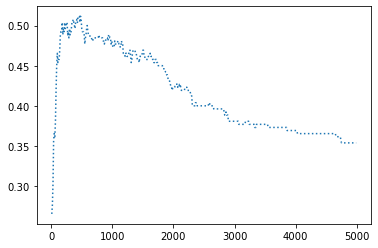

In [9]:
# Strategy 17: Naive Bayes Model on lead_3_sentences_summary_of_full_article_text

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

x_values = []
accuracy_scores = []
max_feat_num = 0
max_acc_score = 0

for x in range(1, 500):
    feat_num = x*10

    # Load in tfidf
    tfidf = TfidfVectorizer(max_features=feat_num)
    x_values.append(feat_num)

    # Create variables from gv_df to train_test_split
    X_lead = gv_df['lead_3_sentences_summary_of_full_article_text'].astype(pd.StringDtype())
    X_lead = tfidf.fit_transform(X_lead.values.astype('U'))
    y = gv_df['Q3 Theme1']

    # Split training set into training and testing set
    X_train, X_test, Y_train, Y_test = train_test_split(
            X_lead,
            y,
            test_size=0.20,
            random_state=0
        )

    nb = MultinomialNB().fit(X_train, Y_train)
    nb_lead_y_preds = nb.predict(X_test)
    acc_score = accuracy_score(Y_test, nb_lead_y_preds)
    accuracy_scores.append(acc_score)
    if (acc_score > max_acc_score):
        max_acc_score = acc_score
        max_feat_num = feat_num
    
plt.plot(x_values, accuracy_scores, linestyle = 'dotted')

#print("Accuracy Score on NB body testing set = ", accuracy_score(Y_test, nb_lead_y_preds))
print("Max Accuracy Score on Naive Bayes Lead 3 Sentence data = ", max_acc_score, " at max features = ",  max_feat_num)
nb_lead_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':nb_lead_y_preds})

In [67]:
target_names = ["Gun/2nd Amendment", "Gun Control", "Politics", "Mental Health", "School/Public Safety", "Race/Ethnicity", "Public Opinion", "Society/culture", "Economic Consequences"]
classification_report(Y_test, nb_lead_y_preds, target_names=target_names)

C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'                       precision    recall  f1-score   support\n\n    Gun/2nd Amendment       0.00      0.00      0.00         9\n          Gun Control       0.71      0.18      0.29        55\n             Politics       0.30      0.97      0.46        89\n        Mental Health       0.00      0.00      0.00        17\n School/Public Safety       0.00      0.00      0.00        32\n       Race/Ethnicity       1.00      0.04      0.07        27\n       Public Opinion       0.75      0.27      0.40        67\n      Society/culture       0.00      0.00      0.00        11\nEconomic Consequences       0.00      0.00      0.00        18\n\n             accuracy                           0.35       325\n            macro avg       0.31      0.16      0.14       325\n         weighted avg       0.44      0.35      0.26       325\n'

Max Accuracy Score on Naive Bayes presum data =  0.48846153846153845  at max features =  460


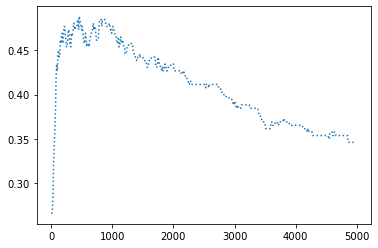

In [10]:
# Strategy 18: Naive Bayes Model on presum_summary_of_full_article_text

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

x_values = []
accuracy_scores = []
max_feat_num = 0
max_acc_score = 0

for x in range(1, 500):
    feat_num = x*10

    # Load in tfidf
    tfidf = TfidfVectorizer(max_features=feat_num)
    x_values.append(feat_num)

    # Create variables from gv_df to train_test_split
    X_pre = gv_df['presum_summary_of_full_article_text'].astype(pd.StringDtype())
    X_pre = tfidf.fit_transform(X_pre.values.astype('U'))
    y = gv_df['Q3 Theme1']

    # Split training set into training and testing set
    X_train, X_test, Y_train, Y_test = train_test_split(
            X_pre,
            y,
            test_size=0.20,
            random_state=0
        )

    nb = MultinomialNB().fit(X_train, Y_train)
    nb_pre_y_preds = nb.predict(X_test)
    acc_score = accuracy_score(Y_test, nb_pre_y_preds)
    accuracy_scores.append(acc_score)
    if (acc_score > max_acc_score):
        max_acc_score = acc_score
        max_feat_num = feat_num
    
plt.plot(x_values, accuracy_scores, linestyle = 'dotted')

#print("Accuracy Score on NB body testing set = ", accuracy_score(Y_test, nb_pre_y_preds))
print("Max Accuracy Score on Naive Bayes presum data = ", max_acc_score, " at max features = ",  max_feat_num)
nb_pre_results = pd.DataFrame({'Y_test':Y_test, 'y_preds':nb_pre_y_preds})

In [69]:
target_names = ["Gun/2nd Amendment", "Gun Control", "Politics", "Mental Health", "School/Public Safety", "Race/Ethnicity", "Public Opinion", "Society/culture", "Economic Consequences"]
classification_report(Y_test, nb_pre_y_preds, target_names=target_names)

C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mattg\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'                       precision    recall  f1-score   support\n\n    Gun/2nd Amendment       0.00      0.00      0.00         9\n          Gun Control       0.80      0.15      0.25        55\n             Politics       0.30      0.99      0.46        89\n        Mental Health       0.00      0.00      0.00        17\n School/Public Safety       0.00      0.00      0.00        32\n       Race/Ethnicity       1.00      0.07      0.14        27\n       Public Opinion       0.68      0.19      0.30        67\n      Society/culture       0.00      0.00      0.00        11\nEconomic Consequences       0.00      0.00      0.00        18\n\n             accuracy                           0.34       325\n            macro avg       0.31      0.16      0.13       325\n         weighted avg       0.44      0.34      0.24       325\n'